In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from functools import reduce
from scipy.io import loadmat
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(3)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


3


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        trM.append(np.where(mask == 0.0, 0, 1)) #0, 1
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path,0).astype(np.float32), (256, 256))/255#(256,256)
        teM.append(np.where(mask == 0.0, 0, 1))
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 91 seconds


In [3]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        feat = self.layer4(x)

        x = self.avgpool(feat)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return feat, x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

 328 / 328 : loss = 0.653225Eopch:     1 mean_loss = 0.749126
 328 / 328 : loss = 0.623656Eopch:     2 mean_loss = 0.697191
 328 / 328 : loss = 0.657268Eopch:     3 mean_loss = 0.681978
 328 / 328 : loss = 0.817043Eopch:     4 mean_loss = 0.675517
 328 / 328 : loss = 0.622572Eopch:     5 mean_loss = 0.668334
 328 / 328 : loss = 0.724422Eopch:     6 mean_loss = 0.650932
 328 / 328 : loss = 0.610331Eopch:     7 mean_loss = 0.654554
 328 / 328 : loss = 0.682249Eopch:     8 mean_loss = 0.672526
 328 / 328 : loss = 0.583935Eopch:     9 mean_loss = 0.677989
 328 / 328 : loss = 0.730991Eopch:    10 mean_loss = 0.664373
best_loss = 0.650932
 36 / 37 Sensitivity(TPR) of Benign: 0.534884
Sensitivity(TPR) of Malignant: 0.720207
AUC (Area Under Curve) of Micro: 0.476684


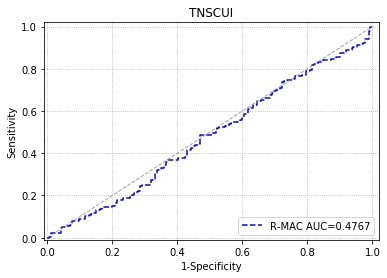

In [10]:
#define model
model = resnet50(num_classes=2).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _,Out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = ce_loss(Out_batch,Y_batch)#loss
        #backward
        loss.backward()
        optimizer.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
torch.cuda.empty_cache()

#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    _,out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Benign: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Malignant: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('TNSCUI')
plt.show()

In [11]:
#release gpu memory and save model in CPU
model = model.cpu()
ce_loss = ce_loss.cpu()
best_net = best_net.cpu()
torch.cuda.empty_cache() 
torch.save(best_net.state_dict(), '/data/tmpexec/CAM.pkl')

In [12]:
'''
#Code: https://github.com/imatge-upc/retrieval-2017-cam
#Paper: BMVC2017《Class-Weighted Convolutional Features for Image Retrieval》
'''
# Extract region of interest from CAMs
def extract_ROI(heatmap, threshold):
    th = threshold * np.max(heatmap)
    heatmap = heatmap > th
    # Find the largest connected component

    contours, hierarchy = cv2.findContours(heatmap.astype('uint8'), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(ctr) for ctr in contours]

    max_contour = contours[areas.index(max(areas))]

    x, y, w, h = cv2.boundingRect(max_contour)
    if w == 0:
        w = heatmap.shape[1]
    if h == 0:
        h = heatmap.shape[0]
    return x, y, w, h

def compute_crow_channel_weight(X):
    """
    Given a tensor of features, compute channel weights as the
    log of inverse channel sparsity.
    :param ndarray X:
        3d tensor of activations with dimensions (channels, height, width)
    :returns ndarray:
        a channel weight vector
    """
    K, w, h = X.shape
    area = float(w * h)
    nonzeros = np.zeros(K, dtype=np.float32)
    for i, x in enumerate(X):
        nonzeros[i] = np.count_nonzero(x) / area

    nzsum = nonzeros.sum()
    for i, d in enumerate(nonzeros):
        nonzeros[i] = np.log(nzsum / d) if d > 0. else 0.

    return nonzeros

def compute_pca(descriptors, pca_dim=512, whiten=True):
    print (descriptors.shape)
    t1 = time.time()
    print( 'Computing PCA with dimension reduction to: ', pca_dim)
    sys.stdout.flush()
    pca = PCA(n_components=pca_dim, whiten=whiten)
    pca.fit(descriptors)
    print (pca.components_.shape)
    print ('PCA finished!')
    print ('Time elapsed computing PCA: ', time.time() - t1)
    return pca


def sum_pooling(features):
    num_samples = features.shape[0]
    num_features = features.shape[1]
    sys.stdout.flush()
    descriptors = np.zeros((num_samples, num_features), dtype=np.float32)
    for i in range(0, num_samples):
        #print 'Image: ', i
        #sys.stdout.flush()
        for f in range(0, num_features):
            descriptors[i, f] = features[i, f].sum()
    descriptors /= np.linalg.norm(descriptors, axis=1)[:, None]
    return descriptors

def weighted_cam_pooling(features, cams, max_pool=False, channel_weights=True):
    '''
    :param features: Feature Maps
    :param cams: Class Activation Maps
    :param max_pool: Perform also Max pooling
    :param channel_weights: Channel Weighting as in Crow
    :return: A descriptor for each CAM.
    '''
    t = time.time()
    num_samples = features.shape[0]
    num_features = features.shape[1]
    num_classes = cams.shape[1]

    wp_regions = np.zeros((num_features, num_classes), dtype=np.float32)
    wsp_descriptors_reg = np.zeros((num_samples * num_classes, num_features), dtype=np.float32)
    wmp_descriptors_reg = np.zeros((num_samples * num_classes, num_features), dtype=np.float32)

    if max_pool:
        mp_regions = np.zeros((num_features, num_classes), dtype=np.float32)

    for i in range(0, num_samples):
        #CROW
        if channel_weights:
            C = np.array(compute_crow_channel_weight(features[i]))

        for f in range(0, num_features):
            for k in range(0, num_classes):
                # For each region compute avg weighted sum of activations and l2 normalize
                if max_pool:
                        mp_regions[f, k] = np.amax(np.multiply(features[i, f], cams[i, k]))
                wp_regions[f, k] = np.multiply(features[i, f], cams[i, k]).sum()

        if channel_weights:
            wp_regions = wp_regions * C[:, None]
        wp_regions /= np.linalg.norm(wp_regions, axis=0)

        if max_pool:
            if channel_weights:
                mp_regions = mp_regions * C[:, None]
            mp_regions /= np.linalg.norm(mp_regions, axis=0)

        wsp_descriptors_reg[num_classes*i:num_classes*(i+1)] = np.transpose(wp_regions)

        if max_pool:
            wmp_descriptors_reg[num_classes*i:num_classes*(i+1)] = np.transpose(mp_regions)

    #print 'Time elapsed computing image representations for the batch: ', time.time() - t

    if max_pool:
        return wsp_descriptors_reg, wmp_descriptors_reg
    else:
        return wsp_descriptors_reg
    
# General Descriptor Aggregation : PCA + Aggregation
def descriptor_aggregation(descriptors_cams, num_images, num_classes, pca=None):

    num_classes_ori = int(descriptors_cams.shape[0] / num_images)
    descriptors = np.zeros((num_images, descriptors_cams.shape[1]), dtype=np.float32)

    if pca is not None:
        # Sometimes we may have errors during re-ranking due to bounding box generation on places where CAM=0
        try:
            descriptors_pca = pca.transform(descriptors_cams)
        except:
            print ('---------------------------->Exception')
            desc_err = np.zeros((descriptors_cams.shape[0], descriptors_cams.shape[1]), dtype=np.float32)
            for j in range(0, descriptors_cams.shape[0]):
                try:
                    desc_err[j] = pca.transform(descriptors_cams[j])
                except:
                    print ('---------------------------->Exception')
                    print (j)
                    desc_err[j] = desc_err[j-1]
            descriptors_pca = desc_err

        descriptors = np.zeros((num_images, descriptors_pca.shape[1]), dtype=np.float32)
        #print descriptors_pca.shape

    index = 0
    for i in range(0, num_images):
        index = num_classes_ori + index
        if i == 0:
            index = 0
        if pca is not None:
            for k in range(index, index+num_classes):
                descriptors_pca[k] /= np.linalg.norm(descriptors_pca[k])
                descriptors[i] += descriptors_pca[k]

            descriptors[i] /= np.linalg.norm(descriptors[i])
        else:
            for k in range(index, index+num_classes):
                descriptors[i] += descriptors_cams[k]
            descriptors[i] /= np.linalg.norm(descriptors[i])

    return descriptors

#load model and transfer to GPU
device = torch.device("cuda")
best_net = resnet50(num_classes=2)
best_net.load_state_dict(torch.load( '/data/tmpexec/CAM.pkl'))
best_net.to(device)

weights_fc = best_net.fc.state_dict()['weight'] #tensor([2, 2048])
weights_fc = np.transpose(weights_fc.cpu().numpy(), (1, 0)) #numpy(2048, 2)
#extract feature-cam for trainset
batchSize=10
num_samples = len(trI)
n_classes = 2
class_list = np.zeros((num_samples, n_classes), dtype=np.int32)
scores_vec = list()
# Region of interest for re-ranking (bounding box coordinates --> (num samples, num_thresholds, x,y,dx,dy)
bbox_coord = np.zeros((num_samples, 5, 4), dtype=np.int16)
num_batches = len(trI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    conv_outputs_cam, scores = best_net(x_batch.permute(0, 3, 1, 2))#forword
    conv_outputs_cam = conv_outputs_cam.data.cpu().numpy()
    scores = scores.data.cpu().numpy()
    if i == 0:
        features_conv = np.zeros((num_samples, conv_outputs_cam.shape[1], conv_outputs_cam.shape[2], conv_outputs_cam.shape[3]))
        cams = np.zeros((num_samples, n_classes, conv_outputs_cam.shape[2], conv_outputs_cam.shape[3]))
        features_conv[min_idx:max_idx, :, :, :] = conv_outputs_cam
    else:
        features_conv[min_idx:max_idx, :, :, :] = conv_outputs_cam
    
    for ii in range(0, max_idx-min_idx):
        indexed_scores = scores[ii].argsort()[::-1]
        scores_vec.append(scores[ii])
        for k in range(0, n_classes):
            w_class = weights_fc[:, indexed_scores[k]]
            cam = np.zeros(dtype=np.float32, shape=conv_outputs_cam.shape[2:4])
            for ind, w in enumerate(w_class):
                cam += w * conv_outputs_cam[ii, ind, :, :]
            cam /= np.max(cam)
            cam[np.where(cam < 0)] = 0
            cams[min_idx+ii, k, :, :] = cam
            class_list[min_idx+ii, k] = indexed_scores[k]
            
        heatmap = cams[min_idx+ii, 0]
        bbox_coord[min_idx+ii, 0, :] = extract_ROI(heatmap=heatmap, threshold=0.01)# Full Image
        bbox_coord[min_idx+ii, 1, :] = extract_ROI(heatmap=heatmap, threshold=0.1)
        bbox_coord[min_idx+ii, 2, :] = extract_ROI(heatmap=heatmap, threshold=0.2)
        bbox_coord[min_idx+ii, 3, :] = extract_ROI(heatmap=heatmap, threshold=0.3)
        bbox_coord[min_idx+ii, 4, :] = extract_ROI(heatmap=heatmap, threshold=0.4)
#output: features_conv, cams, class_list, scores_vec, bbox_coord
#extract features    
d_wp = weighted_cam_pooling(features_conv, cams)
#d_sp = sum_pooling(features_conv)
# Compute Query Descriptor
trF = descriptor_aggregation(d_wp, num_samples, n_classes)
trF_pca = compute_pca(trF)

#extract feature-cam for testset
batchSize=10
num_samples = len(teI)
n_classes = 2
class_list = np.zeros((num_samples, n_classes), dtype=np.int32)
scores_vec = list()
# Region of interest for re-ranking (bounding box coordinates --> (num samples, num_thresholds, x,y,dx,dy)
bbox_coord = np.zeros((num_samples, 5, 4), dtype=np.int16)
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    conv_outputs_cam, scores = best_net(x_batch.permute(0, 3, 1, 2))#forword
    conv_outputs_cam = conv_outputs_cam.data.cpu().numpy()
    scores = scores.data.cpu().numpy()
    if i == 0:
        features_conv = np.zeros((num_samples, conv_outputs_cam.shape[1], conv_outputs_cam.shape[2], conv_outputs_cam.shape[3]))
        cams = np.zeros((num_samples, n_classes, conv_outputs_cam.shape[2], conv_outputs_cam.shape[3]))
        features_conv[min_idx:max_idx, :, :, :] = conv_outputs_cam
    else:
        features_conv[min_idx:max_idx, :, :, :] = conv_outputs_cam
    
    for ii in range(0, max_idx-min_idx):
        indexed_scores = scores[ii].argsort()[::-1]
        scores_vec.append(scores[ii])
        for k in range(0, n_classes):
            w_class = weights_fc[:, indexed_scores[k]]
            cam = np.zeros(dtype=np.float32, shape=conv_outputs_cam.shape[2:4])
            for ind, w in enumerate(w_class):
                cam += w * conv_outputs_cam[ii, ind, :, :]
            cam /= np.max(cam)
            cam[np.where(cam < 0)] = 0
            cams[min_idx+ii, k, :, :] = cam
            class_list[min_idx+ii, k] = indexed_scores[k]
            
        heatmap = cams[min_idx+ii, 0]
        bbox_coord[min_idx+ii, 0, :] = extract_ROI(heatmap=heatmap, threshold=0.01)# Full Image
        bbox_coord[min_idx+ii, 1, :] = extract_ROI(heatmap=heatmap, threshold=0.1)
        bbox_coord[min_idx+ii, 2, :] = extract_ROI(heatmap=heatmap, threshold=0.2)
        bbox_coord[min_idx+ii, 3, :] = extract_ROI(heatmap=heatmap, threshold=0.3)
        bbox_coord[min_idx+ii, 4, :] = extract_ROI(heatmap=heatmap, threshold=0.4)
#output: features_conv, cams, class_list, scores_vec, bbox_coord
#extract features    
d_wp = weighted_cam_pooling(features_conv, cams)
#d_sp = sum_pooling(features_conv)
# Compute Query Descriptor
teF = descriptor_aggregation(d_wp, num_samples, n_classes)
#teF_pca = compute_pca(teF)

#compute the size of lesion
def Func_IOU_size(pred,target):
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(2048) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [5, 10, 20, 50]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

(3279, 2048)
Computing PCA with dimension reduction to:  512
(512, 2048)
PCA finished!
Time elapsed computing PCA:  0.948509693145752
Completed buliding index in 22 seconds
mAP=0.4224, mIoU=0.4021
mAP=0.3826, mIoU=0.4015
mAP=0.3521, mIoU=0.4003
mAP=0.3222, mIoU=0.3956


In [21]:
best_net = best_net.cpu()
x_batch = x_batch.cpu()
torch.cuda.empty_cache() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


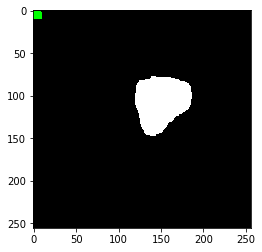

In [34]:
rec = bbox_coord[0]
x, y, w, h = rec[0]
img = teM[0]
#img = cv2.resize(img,(8,8))
cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 4)
imgplot = plt.imshow(img)
plt.show()

(8, 8)


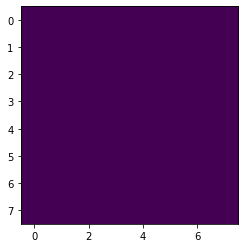

In [37]:
print(features_conv[0][0].shape)
imgplot = plt.imshow(features_conv[0][0])
plt.show()